In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

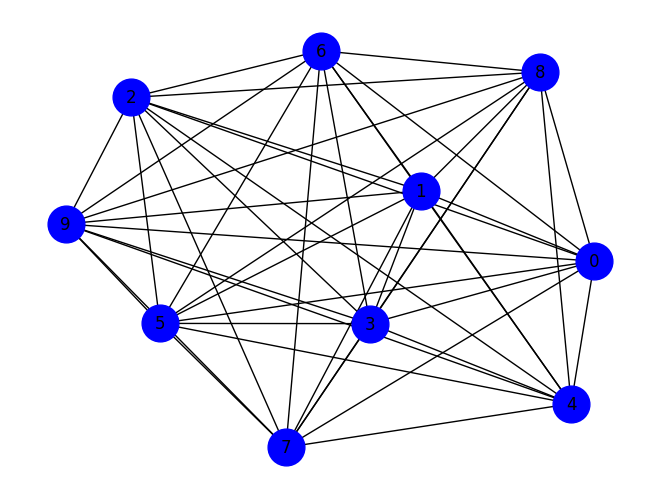

In [19]:
def generate_network_graph(number_nodes):
    graph = nx.complete_graph(number_nodes)  # Realistic topology
    for (u, v) in graph.edges():
        graph.edges[u, v]['latency'] = np.random.randint(1, 20)  # Latency in ms
        graph.edges[u, v]['traffic'] = np.random.randint(1, 10)  # Simulated traffic load
        graph.edges[u, v]['weight'] = (
            graph.edges[u, v]['latency'] + graph.edges[u, v]['traffic']
        )  # Combined metric
    return graph

# Generate the graph and visualize it
number_nodes = 10  # Number of nodes or locations
graph = generate_network_graph(number_nodes)
nx.draw(graph, with_labels=True, node_color='blue', node_size=700, font_size=12)
plt.show()


In [20]:
# Parameters
num_bees = 10
max_iterations = 100
alpha = 0.8  # Trade-off between exploration and exploitation

# Extract adjacency matrix from the graph
def graph_to_adjacency_matrix(graph):
    num_nodes = len(graph.nodes())
    adjacency_matrix = np.zeros((num_nodes, num_nodes))
    for (u, v, data) in graph.edges(data=True):
        adjacency_matrix[u][v] = data['weight']
        adjacency_matrix[v][u] = data['weight']  # Ensure symmetry
    return adjacency_matrix


adjacency_matrix = graph_to_adjacency_matrix(graph)
print("Adjacency Matrix:")
print(adjacency_matrix)

def calculate_path_cost(matrix, path):
    return sum(matrix[path[i]][path[i+1]] for i in range(len(path) - 1)) + matrix[path[-1]][path[0]]

def probabilistic_selection(matrix, current_node, unvisited_nodes):
    """
    Select the next node probabilistically based on edge weights (1/distance).
    """
    unvisited_nodes_list = list(unvisited_nodes)  # Convert set to list
    probabilities = []
    total = 0
    for node in unvisited_nodes_list:
        weight = 1 / (matrix[current_node][node] + 1e-6)  # Avoid division by zero
        probabilities.append(weight)
        total += weight

    probabilities = [p / total for p in probabilities]  # Normalize probabilities
    return random.choices(unvisited_nodes_list, probabilities)[0]

def generate_initial_paths(matrix, num_bees):
    """
    Generate initial random paths for all bees.
    """
    nodes = list(range(len(matrix)))
    paths = []
    for _ in range(num_bees):
        path = nodes[:]
        random.shuffle(path)
        paths.append(path)
    return paths

def local_refinement(matrix, path):
    """
    Use a simple 2-opt swap for local optimization.
    """
    best_path = path[:]
    best_cost = calculate_path_cost(matrix, path)
    for i in range(len(path) - 1):
        for j in range(i + 1, len(path)):
            new_path = path[:]
            new_path[i:j+1] = reversed(new_path[i:j+1])
            new_cost = calculate_path_cost(matrix, new_path)
            if new_cost < best_cost:
                best_path = new_path
                best_cost = new_cost
    return best_path

def bee_colony_optimization(matrix, num_bees, max_iterations, alpha):
    """
    Main BCO algorithm with enhancements.
    """
    # Initialization
    paths = generate_initial_paths(matrix, num_bees)
    best_global_path = None
    best_global_cost = float('inf')

    for iteration in range(max_iterations):
        new_paths = []

        # Exploration and exploitation
        for path in paths:
            current_path = path[:1]  # Start with the first node
            unvisited_nodes = set(path[1:])

            # Probabilistic node selection
            while unvisited_nodes:
                current_node = current_path[-1]
                next_node = probabilistic_selection(matrix, current_node, unvisited_nodes)
                current_path.append(next_node)
                unvisited_nodes.remove(next_node)

            # Local refinement
            refined_path = local_refinement(matrix, current_path)
            refined_cost = calculate_path_cost(matrix, refined_path)

            # Update best path
            if refined_cost < best_global_cost:
                best_global_path = refined_path
                best_global_cost = refined_cost

            new_paths.append(refined_path)

        # Elitism: Retain the best solutions
        new_paths = sorted(new_paths, key=lambda path: calculate_path_cost(matrix, path))
        paths = new_paths[:int(num_bees * alpha)] + generate_initial_paths(matrix, num_bees - int(num_bees * alpha))
        # Periodic randomization to escape local optima
        if iteration % 10 == 0:
            random.shuffle(paths)

        # Logging
        print(f"Iteration {iteration+1}: Best Cost = {best_global_cost}, Best Path = {best_global_path}")

    return best_global_path, best_global_cost

Adjacency Matrix:
[[ 0. 20.  2. 20. 18. 11. 14. 19. 14. 18.]
 [20.  0. 20.  6. 21. 13. 13. 21. 20.  7.]
 [ 2. 20.  0. 18. 10. 18. 16.  8. 12. 18.]
 [20.  6. 18.  0. 19. 13.  7. 19. 20. 18.]
 [18. 21. 10. 19.  0. 15. 11. 11.  9.  2.]
 [11. 13. 18. 13. 15.  0. 13.  8. 10. 22.]
 [14. 13. 16.  7. 11. 13.  0. 11. 22. 18.]
 [19. 21.  8. 19. 11.  8. 11.  0.  5. 18.]
 [14. 20. 12. 20.  9. 10. 22.  5.  0. 11.]
 [18.  7. 18. 18.  2. 22. 18. 18. 11.  0.]]


In [21]:
# Run the BCO algorithm
best_path, best_cost = bee_colony_optimization(adjacency_matrix, num_bees, max_iterations, alpha)
print("Best Path:", best_path)
print("Best Cost:", best_cost)

Iteration 1: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 2: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 3: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 4: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 5: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 6: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 7: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 8: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 9: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 10: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 11: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 12: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 13: Best Cost = 70.0, Best Path = [2, 0, 5, 6, 3, 1, 9, 4, 8, 7]
Iteration 14: Best Cost = 70.0, Be

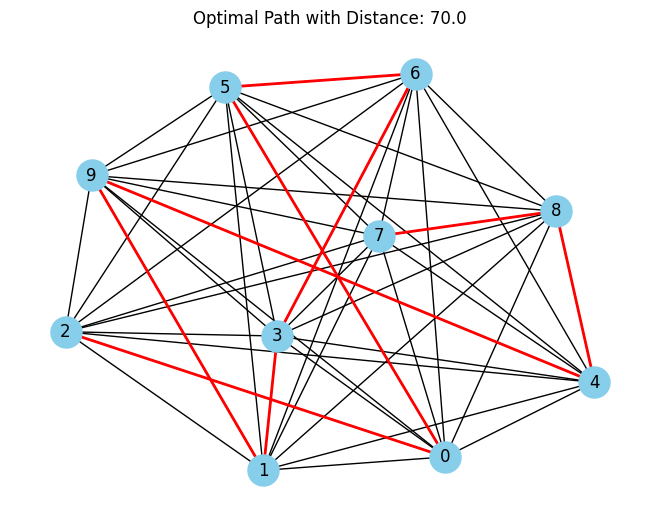

In [22]:
# Draw the graph with the optimal path
def draw_path(graph, path, best_distance):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=12)
    path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2)
    plt.title(f"Optimal Path with Distance: {best_distance}")
    plt.show()

draw_path(graph, best_path, best_cost)